In [ ]:
import os
import cv2
import PIL
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

#**Lung Segmentation**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob

In [ ]:
os.chdir('/content/drive/My Drive/ME 781/Project/data_set')

FileNotFoundError: ignored

In [ ]:
img_list = sorted(glob.glob('2d_images/*.tif'))
mask_list = sorted(glob.glob('2d_masks/*.tif'))
print(len(img_list), len(mask_list))

267 267


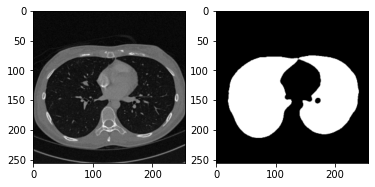

In [ ]:
IMG_SIZE = 256

x_data, y_data = np.empty((2, len(img_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
'''
x_data, y_data are data procurment for the Segmentation Model
x_data original data and y_data is segmentation image
img contains image data
'''
for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # img=(np.abs(img)/np.max(np.abs(img)))*255
    x_data[i] = img
    
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # img=(np.abs(img)/np.max(np.abs(img)))*255
    y_data[i] = img
    
y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1)
'''
x_train, x_val, y_train, y_val are data partitions
'''
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


#**Our Data Genarator**

In [ ]:
os.chdir('/content/drive/My Drive/ME 781/Project/covid-19 dataset')
path=os.getcwd()
folders=os.listdir(path)
f=path+"/"+folders[1]+'/train'
dat_folders=os.listdir(f)
dat_folder_covid=f+'/'+dat_folders[0]
images=os.listdir(dat_folder_covid)
'''
dat_folders : Is the list of image files that we imported
dat_folders_covid :  contains Related image names
'''

In [ ]:
datagen = ImageDataGenerator(rescale=255.0,samplewise_center=True,samplewise_std_normalization=True)
datagen.fit(x_train)
'''
datagen : Learns image parametrs to scale 
'''

In [ ]:
train_labels=datagen.flow_from_directory(
    directory=path+"/"+folders[1]+'/train', target_size=(256, 256), color_mode='grayscale', classes=['covid','non-covid'],
    # save_to_dir='/content/drive/My Drive/ME 781/Project/Processed_Images/Train', save_prefix='musk', save_format='png',
    class_mode='categorical', batch_size=1)
'''
train_labels : Imported and scaled the images
'''

Found 722 images belonging to 2 classes.


In [ ]:
test_labels=datagen.flow_from_directory(
    directory=path+"/"+folders[1]+'/test', target_size=(256, 256), color_mode='grayscale', classes=['covid', 'non-covid'],
    # save_to_dir='/content/drive/My Drive/ME 781/Project/Processed_Images/Test', save_prefix='musk', save_format='png',
    class_mode='categorical', batch_size=1)
'''
test_labels : Imported and scaled the images
'''

Found 24 images belonging to 2 classes.


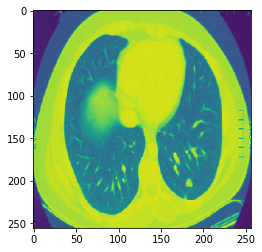

In [ ]:
plt.imshow(train_labels[0][0][0].reshape((256,256)))

#**Model**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [ ]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])
'''
net : defined here is our general U-Net model that is generally used for Medical Image Segmentation  
'''

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=1, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])
'''
Model is fitted with adam optimizer and binary crossentropy with 50 epochs 
and 1 batch size with lr is 1e-05 and also ReduceLROnPlateau is also being used
'''

Epoch 1/50
240/240 [==============================] - 162s 673ms/step - loss: 0.3957 - acc: 0.7758 - mse: 0.1309 - val_loss: 0.3112 - val_acc: 0.7861 - val_mse: 0.1029
Epoch 2/50
240/240 [==============================] - 160s 668ms/step - loss: 0.2457 - acc: 0.8690 - mse: 0.0751 - val_loss: 0.2604 - val_acc: 0.8571 - val_mse: 0.0843
Epoch 3/50
240/240 [==============================] - 161s 670ms/step - loss: 0.1790 - acc: 0.9041 - mse: 0.0508 - val_loss: 0.1052 - val_acc: 0.9459 - val_mse: 0.0282
Epoch 4/50
240/240 [==============================] - 160s 669ms/step - loss: 0.1029 - acc: 0.9443 - mse: 0.0246 - val_loss: 0.1026 - val_acc: 0.9487 - val_mse: 0.0245
Epoch 5/50
240/240 [==============================] - 160s 668ms/step - loss: 0.0834 - acc: 0.9507 - mse: 0.0190 - val_loss: 0.0561 - val_acc: 0.9573 - val_mse: 0.0136
Epoch 6/50
240/240 [==============================] - 161s 671ms/step - loss: 0.0740 - acc: 0.9539 - mse: 0.0159 - val_loss: 0.0475 - val_acc: 0.9610 - val_mse:

#**Prediction**

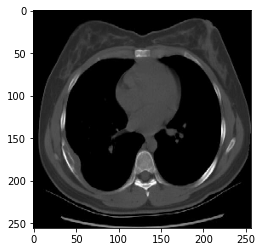

In [ ]:
#train_labels is our data from ImageDataGenerator
my_image=train_labels[20][0][0]*100
my_image.resize((1,256,256,1))
predicted_mask=model.predict(my_image)
plt.imshow(my_image.squeeze(),cmap='gray')
'''
my_image :  Is our required scaled images

predicted_mask : is the output segmented image
'''

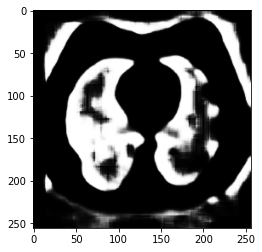

In [ ]:
plt.imshow(predicted_mask.squeeze(),cmap='gray')

#**Saving the Image**

In [ ]:
import matplotlib

In [ ]:
os.chdir('/content/drive/My Drive/ME 781/Project/Processed_Images/Test')

In [ ]:
c=0
for i in range(24):
  t=test_labels[i][0][0]
  my_image=t*100
  my_image.resize((1,256,256,1))
  predicted_mask=model.predict(my_image)
  # plt.imshow(my_image.squeeze(),cmap='gray')  
  label=test_labels[i][1][0]
  if label[0]==1:
    matplotlib.image.imsave('covid/'+str(c)+'.png', predicted_mask.squeeze().squeeze())
    c=c+1
  elif label[0]==0:
    matplotlib.image.imsave('non-covid/'+str(c)+'.png', predicted_mask.squeeze().squeeze())
    c=c+1

In [ ]:
os.chdir('/content/drive/My Drive/ME 781/Project/Processed_Images/Train')

In [ ]:
c=0
for i in range(722):
  t=train_labels[i][0][0]
  my_image=t*100
  my_image.resize((1,256,256,1))
  predicted_mask=model.predict(my_image)
  # plt.imshow(my_image.squeeze(),cmap='gray')  
  label=train_labels[i][1][0]
  if label[0]==1:
    matplotlib.image.imsave('covid/'+str(c)+'.png', predicted_mask.squeeze().squeeze())
    c=c+1
  elif label[0]==0:
    matplotlib.image.imsave('non-covid/'+str(c)+'.png', predicted_mask.squeeze().squeeze())
    c=c+1

In [ ]:
!python -m pydoc Segementation_and_generator_file.ipynb

No Python documentation found for 'Segementation_and_generator_file.ipynb'.
Use help() to get the interactive help utility.
Use help(str) for help on the str class.

